In [101]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
#from scipy.optimize import curve_fit

#import scvi
import pickle
from adjustText import adjust_text

import itertools
#from numba import jit

import gseapy as gp
import random

import subprocess
from io import StringIO
from Bio import SeqIO

In [102]:
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data_BDATA.h5ad')

In [103]:
len(adata.var_names)

20116

In [5]:
class_d = pd.read_csv('../data/annotations/cell_class_annotation.csv')
class_d['class'] = class_d['class'].replace('resident immune', 'immune')

class_d['cell_type_2'] = class_d.cell_ontology_class.map(dict(zip(adata.obs.cell_ontology_class, adata.obs.cell_type_2)))


class_d = dict(zip(class_d.cell_type_2, class_d['class']))

class_d['monocyte'] = 'immune'

# Most common - signature

In [3]:
import senepy as sp

In [4]:
sigs = sp.load_hubs(species = 'Mouse', sig_type = 'cell_type')

In [5]:
signatures = sigs.hubs

In [6]:
all_genes_redundant = []

for x in list(signatures):
    all_genes_redundant += [x[0] for x in signatures[x]]

In [7]:
signatures

{('Bladder', 'bladder cell'): [('Rspo1', 33),
  ('Me3', 11),
  ('Clic3', 27),
  ('Slpi', 30),
  ('Cdh3', 37),
  ('Prlr', 28),
  ('Hoxc6', 27),
  ('Pcnxl2', 27),
  ('Wt1', 39),
  ('Dpp4', 50),
  ('Podxl', 33),
  ('Msln', 32),
  ('Sgcd', 20),
  ('Smpd3', 39),
  ('Nrxn2', 14),
  ('Slurp1', 29),
  ('Hoxc4', 17),
  ('Prr15l', 34),
  ('Bex1', 8),
  ('Syt7', 14),
  ('Espn', 28),
  ('Gpm6a', 35),
  ('Slc4a8', 26),
  ('Hoxd10', 21),
  ('Gpr64', 31),
  ('Ablim3', 29),
  ('Hoxd13', 10),
  ('Col8a2', 29),
  ('Map3k9', 4),
  ('Bicd1', 20),
  ('Kcnj8', 21),
  ('Myl7', 35),
  ('Cdon', 28),
  ('Pkhd1l1', 33),
  ('Fgf9', 18),
  ('Plscr2', 21),
  ('Matn4', 12),
  ('Rxrg', 21),
  ('Gfra3', 21),
  ('Kcna1', 23),
  ('Kcna2', 23),
  ('Cadm4', 27),
  ('Ppp1r14c', 6),
  ('Mpz', 21),
  ('Plce1', 30),
  ('Rasgef1c', 18),
  ('Cadm2', 32),
  ('Fam89a', 20),
  ('Ngfr', 9),
  ('Slc35f1', 19),
  ('Tmprss5', 17),
  ('Nat8l', 18),
  ('Lgi1', 19),
  ('Sfrp5', 22),
  ('Klk8', 18),
  ('Agtr1a', 32),
  ('Efhd1', 34),
  ('

In [8]:
all_genes_nr = list(set(all_genes_redundant))

In [9]:
len(all_genes_nr)

9645

In [10]:
all_genes_redundant.count('Cdkn2a')

11

In [11]:
#depricated. Now use senePy.load_hubs.merge_hubs

# out = []
# for gene in all_genes_nr:
#     out.append([gene, all_genes_redundant.count(gene)])

# mcs = pd.DataFrame(out, columns = ['gene', 'Count']).sort_values('Count', ascending = False)


# #random distribution of gene commonality counts. ie, how many hubs were a gene in by chance

# out = []
# for x in tqdm(range(10000)):
    
#     all_genes_redundant_temp = []
#     for y in range(len(sig_metadata)):
#         s = sig_metadata.iloc[y].size
#         l = random.choices(adata.var_names, k = s)
#         all_genes_redundant_temp += l
            
#     all_genes_nr_temp = list(set(all_genes_redundant_temp))
    

#     for gene in all_genes_nr_temp:
#         out += [all_genes_redundant.count(gene)]


# out = np.array(out)

# mcs['p'] = mcs['Count'].map(calc_mcg_p)

# mcs['nlogp'] = -np.log10(mcs.p)
# mcs['prev'] = mcs.Count/len(signatures) * 100

# #mcs.to_pickle('../data/files/5.1_mcs.pickle')

# mcs = pd.read_pickle('../data/files/5.1_mcs.pickle')

In [12]:
mcs = sigs.merge_hubs(sigs.metadata,
                new_name = 'Universal',
                calculate_thresh = True,
                bg_N = len(adata.var_names),
                     p_thres = 0.01)

mcs

A gene will occur 5 times at 0.37% chance
Threfore 5 is the calculated_threshold


,Gene,Count,p value,q value
0,Hba-a1,29,0.000000,0.000000
1,Hbb-b1,20,0.000000,0.000000
2,Gm11428,19,0.000000,0.000000
3,Vsig4,18,0.000000,0.000000
4,Saa3,18,0.000000,0.000000
...,...,...,...,...
630,Cd300lf,5,0.000246,0.003735
631,Prkcb,5,0.000246,0.003735
632,Enpp6,5,0.000246,0.003735
633,Slc4a8,5,0.000246,0.003735


In [13]:
mcs['q value'].unique()

array([0.00000000e+00, 2.92039120e-13, 9.36958844e-12, 2.18445262e-10,
       3.61245025e-09, 5.56182462e-08, 7.99213146e-07, 8.91998400e-06,
       7.90851829e-05, 6.50666848e-04, 3.73545445e-03])

In [14]:
mcs['q value'] = mcs['q value'].map(lambda x: 8.55981952e-13 if x == 0 else x) #imputing 0s with next smallest p value

mcs['nlogp'] = -np.log10(mcs['q value'])
mcs['prev'] = mcs.Count/(len(signatures) -1 )* 100 ##### !!!!!! merge_hubs added a signature after so need to remove 1

In [15]:
mcs

,Gene,Count,p value,q value,nlogp,prev
0,Hba-a1,29,0.000000,8.559820e-13,12.067535,67.441860
1,Hbb-b1,20,0.000000,8.559820e-13,12.067535,46.511628
2,Gm11428,19,0.000000,8.559820e-13,12.067535,44.186047
3,Vsig4,18,0.000000,8.559820e-13,12.067535,41.860465
4,Saa3,18,0.000000,8.559820e-13,12.067535,41.860465
...,...,...,...,...,...,...
630,Cd300lf,5,0.000246,3.735454e-03,2.427657,11.627907
631,Prkcb,5,0.000246,3.735454e-03,2.427657,11.627907
632,Enpp6,5,0.000246,3.735454e-03,2.427657,11.627907
633,Slc4a8,5,0.000246,3.735454e-03,2.427657,11.627907


In [16]:
mcs[mcs.prev >= 25]

,Gene,Count,p value,q value,nlogp,prev
0,Hba-a1,29,0.000000e+00,8.559820e-13,12.067535,67.441860
1,Hbb-b1,20,0.000000e+00,8.559820e-13,12.067535,46.511628
2,Gm11428,19,0.000000e+00,8.559820e-13,12.067535,44.186047
3,Vsig4,18,0.000000e+00,8.559820e-13,12.067535,41.860465
4,Saa3,18,0.000000e+00,8.559820e-13,12.067535,41.860465
5,Cxcl13,17,0.000000e+00,8.559820e-13,12.067535,39.534884
6,Igj,17,0.000000e+00,8.559820e-13,12.067535,39.534884
7,Hbb-b2,15,0.000000e+00,8.559820e-13,12.067535,34.883721
8,Elane,15,0.000000e+00,8.559820e-13,12.067535,34.883721
9,Fcna,15,0.000000e+00,8.559820e-13,12.067535,34.883721


In [17]:
len(mcs[mcs.prev >= 25])

37

In [18]:
mcs

,Gene,Count,p value,q value,nlogp,prev
0,Hba-a1,29,0.000000,8.559820e-13,12.067535,67.441860
1,Hbb-b1,20,0.000000,8.559820e-13,12.067535,46.511628
2,Gm11428,19,0.000000,8.559820e-13,12.067535,44.186047
3,Vsig4,18,0.000000,8.559820e-13,12.067535,41.860465
4,Saa3,18,0.000000,8.559820e-13,12.067535,41.860465
...,...,...,...,...,...,...
630,Cd300lf,5,0.000246,3.735454e-03,2.427657,11.627907
631,Prkcb,5,0.000246,3.735454e-03,2.427657,11.627907
632,Enpp6,5,0.000246,3.735454e-03,2.427657,11.627907
633,Slc4a8,5,0.000246,3.735454e-03,2.427657,11.627907


In [19]:
3.735454e-03*100 #i.e. 0.4%

0.3735454

In [20]:
sub = mcs[:30]

#these are the stats for 3% chance based on the data
new_row = {'Gene': '0.4% chance', 'Count': 5, 'p value': 0.000246, 'nlogp':2.427657, 'prev':11.627907}

# append the new row to the DataFrame
#sub = sub.append(new_row, ignore_index=True)
sub = pd.concat((sub, pd.DataFrame([new_row])))

In [21]:
sub

,Gene,Count,p value,q value,nlogp,prev
0,Hba-a1,29,0.000000e+00,8.559820e-13,12.067535,67.441860
1,Hbb-b1,20,0.000000e+00,8.559820e-13,12.067535,46.511628
2,Gm11428,19,0.000000e+00,8.559820e-13,12.067535,44.186047
3,Vsig4,18,0.000000e+00,8.559820e-13,12.067535,41.860465
4,Saa3,18,0.000000e+00,8.559820e-13,12.067535,41.860465
5,Cxcl13,17,0.000000e+00,8.559820e-13,12.067535,39.534884
6,Igj,17,0.000000e+00,8.559820e-13,12.067535,39.534884
7,Hbb-b2,15,0.000000e+00,8.559820e-13,12.067535,34.883721
8,Elane,15,0.000000e+00,8.559820e-13,12.067535,34.883721
9,Fcna,15,0.000000e+00,8.559820e-13,12.067535,34.883721


### Fig 4A

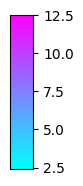

In [22]:


import matplotlib as mpl
from matplotlib import cm

fig, ax = plt.subplots(figsize = (0.3, 2))

cmap = mpl.cm.cool
#norm = mpl.colors.Normalize(vmin = sub.p.min(), vmax = sub.p.max())
norm = mpl.colors.Normalize(vmin = sub.nlogp.min(), vmax = sub.nlogp.max())

mapper = cm.ScalarMappable(norm = norm, cmap = cm.cool)

cbl = mpl.colorbar.ColorbarBase(ax, cmap = cmap, norm = norm, orientation = 'vertical')

plt.savefig('figures/R1_4A_pt2_R1.png', dpi = 600, bbox_inches = 'tight', transparent=True)
plt.savefig('figures/R1_4A_pt2_R1.svg', bbox_inches = 'tight', transparent=True)


/tmp/ipykernel_475417/1681077726.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data = sub, x = 'prev', y = 'Gene', palette = mapper.to_rgba(sub.nlogp.values),
/tmp/ipykernel_475417/1681077726.py:3: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data = sub, x = 'prev', y = 'Gene', palette = mapper.to_rgba(sub.nlogp.values),


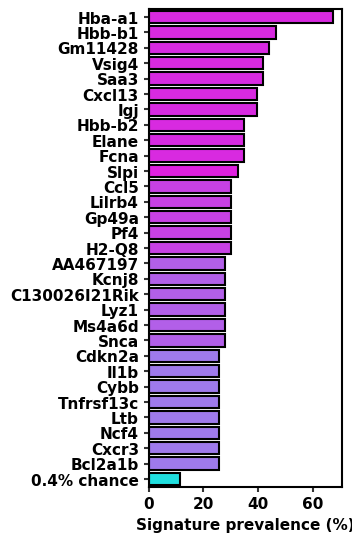

In [23]:
plt.figure(figsize = (2.5,6.2))

ax = sns.barplot(data = sub, x = 'prev', y = 'Gene', palette = mapper.to_rgba(sub.nlogp.values),
                edgecolor = 'k', lw = 1.5)

plt.yticks(size = 11, weight = 'bold')
plt.xticks(size = 11, weight = 'bold')


for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(1.5)
    
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

ax.tick_params(width = 1.5, color = '0.2')


plt.xlabel("Signature prevalence (%)", size = 11, weight = 'bold')
plt.ylabel('')


plt.savefig('figures/R1_4A_pt1_R1.png', dpi = 600, bbox_inches = 'tight', transparent=True)
plt.savefig('figures/R1_4A_pt1_R1.svg', bbox_inches = 'tight', transparent=True)

plt.show()


In [24]:
mcs[mcs.Count >= 8]

,Gene,Count,p value,q value,nlogp,prev
0,Hba-a1,29,0.000000e+00,8.559820e-13,12.067535,67.441860
1,Hbb-b1,20,0.000000e+00,8.559820e-13,12.067535,46.511628
2,Gm11428,19,0.000000e+00,8.559820e-13,12.067535,44.186047
3,Vsig4,18,0.000000e+00,8.559820e-13,12.067535,41.860465
4,Saa3,18,0.000000e+00,8.559820e-13,12.067535,41.860465
...,...,...,...,...,...,...
129,Rspo1,8,1.239272e-07,8.919984e-06,5.049636,18.604651
130,Beta-s,8,1.239272e-07,8.919984e-06,5.049636,18.604651
131,4931408D14Rik,8,1.239272e-07,8.919984e-06,5.049636,18.604651
132,Espn,8,1.239272e-07,8.919984e-06,5.049636,18.604651


In [25]:
enr = gp.enrichr(gene_list= mcs[mcs['q value'] < 0.05].Gene,
             gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2021', 'WikiPathways_2019_Mouse'],
             organism='mouse', # don't forget to set organism to the one you desired!
             outdir=None, # don't write to disk,
             background = len(adata.var_names.tolist())
            )

In [26]:
uni_enr = enr.results

In [27]:
uni_enr = uni_enr[uni_enr['Adjusted P-value'] < 0.05][0:15]
uni_enr['nlog10'] = -np.log10(uni_enr['Adjusted P-value'])

In [28]:
uni_enr

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,nlog10
0,KEGG_2019_Mouse,Cell adhesion molecules (CAMs),35/170,6.830402e-19,1.625636e-16,0,0,8.309259,347.557480,CD274;CD40;ITGAM;H2-Q8;H2-M2;H2-DMA;H2-Q6;ITGB...,15.788977
1,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,44/292,6.707106e-18,7.981456e-16,0,0,5.738961,226.937815,CD40;CCL11;CSF1;CXCR5;MPL;CSF2RB;TNFRSF13C;CXC...,15.097918
2,KEGG_2019_Mouse,Hematopoietic cell lineage,24/94,1.305557e-15,1.035742e-13,0,0,10.827215,371.071914,GYPA;ITGAM;CSF1;ITGA4;IL1R2;H2-DMA;CD8B1;CD3G;...,12.984749
3,KEGG_2019_Mouse,Leishmaniasis,20/67,1.157877e-14,6.889368e-13,0,0,13.366546,428.927143,ITGAM;NCF1;ITGA4;NCF2;PRKCB;H2-DMA;ITGB2;NCF4;...,12.161821
4,KEGG_2019_Mouse,Phagosome,30/180,8.735491e-14,4.158094e-12,0,0,6.352066,190.998987,COLEC11;ITGAM;NCF1;H2-Q8;NCF2;H2-M2;H2-DMA;H2-...,11.381106
5,KEGG_2019_Mouse,Chemokine signaling pathway,31/197,1.678057e-13,6.656293e-12,0,0,5.936019,174.613752,CCL11;NCF1;SRC;CXCR5;WAS;CXCR6;CXCL13;RASGRP2;...,11.176768
6,KEGG_2019_Mouse,Rheumatoid arthritis,18/84,1.141129e-10,3.679836e-09,0,0,8.530573,195.297513,FLT1;CSF1;H2-DMA;ITGB2;MMP3;TNF;TNFSF13B;H2-DM...,8.434172
7,KEGG_2019_Mouse,Staphylococcus aureus infection,19/95,1.236920e-10,3.679836e-09,0,0,7.828328,178.589420,C1RA;ITGAM;H2-DMA;ITGB2;C5AR1;FPR1;FPR2;C4B;C3...,8.434172
8,KEGG_2019_Mouse,Epstein-Barr virus infection,29/229,2.363429e-10,6.249956e-09,0,0,4.585685,101.645086,CD40;H2-Q8;H2-DMA;H2-M2;H2-Q6;H2-Q7;OAS1A;CD3G...,8.204123
9,KEGG_2019_Mouse,Graft-versus-host disease,15/64,1.076126e-09,2.561180e-08,0,0,9.537196,196.942115,H2-T10;H2-Q8;H2-DMA;H2-Q6;H2-M2;H2-Q7;H2-Q2;TN...,7.591560


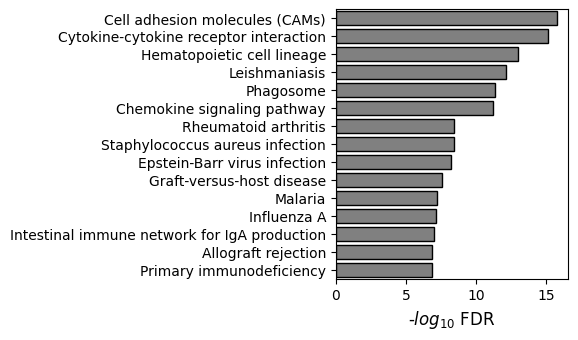

In [29]:

plt.figure(figsize = (3,3.5))

ax = sns.barplot(data = uni_enr, x = 'nlog10', y = 'Term', color = 'grey',
                edgecolor = 'k', lw = 1)

plt.ylabel('')
plt.xlabel("-$log_{10}$ FDR", size = 12)


plt.savefig('figures/R1_4B_R1.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_4B_R1.svg', bbox_inches = 'tight')

plt.show()

In [30]:
enr.results[enr.results.Term.str.contains('NF-')]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
33,KEGG_2019_Mouse,NF-kappa B signaling pathway,13/102,0.000021,0.000144,0,0,4.526681,48.837739,CD40;SYK;PRKCB;TNFRSF13C;TRAF1;TNF;TNFSF13B;IL...
429,GO_Biological_Process_2021,positive regulation of NF-kappaB transcription...,13/155,0.001366,0.019191,0,0,2.829344,18.662573,CD40;PRKCB;TRAF1;TNF;AGER;PRKCZ;AGT;IL6;CLEC7A...
948,GO_Biological_Process_2021,positive regulation of NIK/NF-kappaB signaling...,4/53,0.087200,0.330894,0,0,2.498917,6.096235,IL1B;MMP8;TNF;AGER
989,GO_Biological_Process_2021,regulation of I-kappaB kinase/NF-kappaB signal...,11/224,0.101976,0.365628,0,0,1.585049,3.618693,CD40;PRKCB;CLEC7A;IL1B;CASP1;CCR7;S100A4;TRAF1...
1285,GO_Biological_Process_2021,positive regulation of I-kappaB kinase/NF-kapp...,8/171,0.177931,0.458071,0,0,1.503077,2.594848,CD40;PRKCB;CLEC7A;CASP1;S100A4;CCR7;TNF;LTF
1548,GO_Biological_Process_2021,regulation of NIK/NF-kappaB signaling (GO:1901...,4/80,0.249158,0.495685,0,0,1.608891,2.235824,IL1B;MMP8;TNF;AGER
2012,GO_Biological_Process_2021,activation of NF-kappaB-inducing kinase activi...,1/16,0.403356,0.604586,0,0,2.034700,1.847375,CHI3L1
2563,GO_Biological_Process_2021,NIK/NF-kappaB signaling (GO:0038061),2/74,0.685828,0.792811,0,0,0.846630,0.319288,CHI3L1;PSMB9
2614,GO_Biological_Process_2021,negative regulation of NF-kappaB transcription...,2/79,0.719950,0.816832,0,0,0.791449,0.260049,CDKN2A;NLRC5
2619,GO_Biological_Process_2021,negative regulation of I-kappaB kinase/NF-kapp...,1/40,0.725245,0.820424,0,0,0.781606,0.251088,LILRB4


In [34]:
mcs

,Gene,Count,p value,q value,nlogp,prev
0,Hba-a1,29,0.000000,8.559820e-13,12.067535,67.441860
1,Hbb-b1,20,0.000000,8.559820e-13,12.067535,46.511628
2,Gm11428,19,0.000000,8.559820e-13,12.067535,44.186047
3,Vsig4,18,0.000000,8.559820e-13,12.067535,41.860465
4,Saa3,18,0.000000,8.559820e-13,12.067535,41.860465
...,...,...,...,...,...,...
630,Cd300lf,5,0.000246,3.735454e-03,2.427657,11.627907
631,Prkcb,5,0.000246,3.735454e-03,2.427657,11.627907
632,Enpp6,5,0.000246,3.735454e-03,2.427657,11.627907
633,Slc4a8,5,0.000246,3.735454e-03,2.427657,11.627907


# Universal TF

In [32]:
mm10 = SeqIO.to_dict(SeqIO.parse('scripts/tf/mm10.fa', 'fasta'))

In [36]:

#convert hub list to \n sep string
seq_str = ''
for item in mcs[mcs['p value'] < 0.01].Gene:
    seq_str += str(item) + '\n'

#pass that string to this R script which returns a gene region df
child = subprocess.Popen(['scripts/tf/sym_to_reg.R'], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
child.stdin.write(seq_str.encode())
child_out = child.communicate()[0].decode('utf8')
a = StringIO(child_out)
child.stdin.close()

#read the region df and slice up mm10 into a multi seq fasta
a = pd.read_csv(a).dropna().reset_index(drop = True)
a['slice_start'] = a['slice_start'].astype('int')
a['slice_end'] = a['slice_end'].astype('int')

outfa = []
for row in a.index:
    values = a.iloc[row]
    record = mm10[values.TXCHROM][values.slice_start - 1:values.slice_end -1]
    record.id = values.symbol

    outfa.append(record)


with open('tmpdir/test.fasta', 'w') as f:
    for seq in outfa:
        f.write( '>' + seq.id + '\n')
        f.write(str(seq.seq) + '\n')


#process fasta with meme sea     
child = subprocess.Popen(['sea', '--p', 'tmpdir/test.fasta', '--m',
                      'scripts/tf/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt', 
                      '--text'], stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
child_out = child.communicate()[0].decode('utf8')
a = StringIO(child_out)
a = pd.read_csv(a, delimiter='\t').dropna().drop(columns = ['DB'])




EmptyDataError: No columns to parse from file

In [72]:
out = []


for hub in tqdm(list(signatures)):

    test = signatures[hub]

    test = [x[0] for x in test]


    for i in range(0,10):
        try:
            enr = gp.enrichr(gene_list= test,
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2021', 'WikiPathways_2019_Mouse'],
                         organism='mouse', # don't forget to set organism to the one you desired!
                         outdir=None, # don't write to disk,
                         background = adata.var_names.tolist()
                        )
            break
        except:
            pass
        

    res = enr.results

    res = res[res['Adjusted P-value'] <= 0.05].reset_index(drop = True)
    
    
    res['tissue'] = hub[0]
    res['cell'] = hub[1]
    
    out.append(res)
    

100%|███████████████████████████████████████████| 44/44 [02:58<00:00,  4.07s/it]


In [73]:
#redundant and non-relevant, eg., malaria
redundant = ['Malaria', 'African trypanosomiasis', 'chemokine-mediated signaling pathway (GO:0070098)',
             'granulocyte chemotaxis (GO:0071621)', 
             'Rheumatoid arthritis', 'cellular response to chemokine (GO:1990869)', 
             'Autoimmune thyroid disease', 'Graft-versus-host disease', 'Type I diabetes mellitus',
            'Viral myocarditis', 'Leishmaniasis', 'Allograft rejection', 'Human T-cell leukemia virus 1 infection',
            'Epstein-Barr virus infection', 'neutrophil chemotaxis (GO:0030593)', 'neutrophil activation involved in immune response (GO:0002283)',
            'lymphocyte migration (GO:0072676)', 'cytokine-mediated signaling pathway (GO:0019221)', 'Hematopoietic cell lineage',
            'cellular response to cytokine stimulus (GO:0071345)', 'Staphylococcus aureus infection', 'neutrophil degranulation (GO:0043312)', 
            'negative regulation of lymphocyte proliferation (GO:0050672)']

In [74]:
df = pd.concat(out)

df = df[df.Gene_set != 'WikiPathways_2019_Mouse'] #some redundancy with GO

top_20 = df.groupby('Term').count().sort_values('Gene_set', ascending = False)

top_20 = top_20[~top_20.index.isin(redundant)][0:20]

order_d = dict(zip(top_20.index, range(20)))

overlap_d = dict(zip(top_20.index, top_20.Gene_set))

top_20

,Gene_set,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes,tissue,cell
Term,,,,,,,,,,
Cytokine-cytokine receptor interaction,17,17,17,17,17,17,17,17,17,17
defense response to bacterium (GO:0042742),17,17,17,17,17,17,17,17,17,17
neutrophil migration (GO:1990266),15,15,15,15,15,15,15,15,15,15
inflammatory response (GO:0006954),15,15,15,15,15,15,15,15,15,15
Phagosome,14,14,14,14,14,14,14,14,14,14
regulation of immune response (GO:0050776),14,14,14,14,14,14,14,14,14,14
Cell adhesion molecules (CAMs),12,12,12,12,12,12,12,12,12,12
response to interferon-gamma (GO:0034341),12,12,12,12,12,12,12,12,12,12
neutrophil mediated immunity (GO:0002446),12,12,12,12,12,12,12,12,12,12


In [75]:
to_graph = df[df.Term.isin(top_20.index)]


to_graph['nlog10p'] = -np.log10(to_graph['Adjusted P-value'])

to_graph['Orderer'] = to_graph.Term.map(order_d)

to_graph = to_graph.sort_values('Orderer')


to_graph['Overlap'] = to_graph.Term.map(overlap_d)

#to_graph['frac'] = to_graph['Overlap']/len(hubs) * 100

to_graph

/tmp/ipykernel_475417/2880984902.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_graph['nlog10p'] = -np.log10(to_graph['Adjusted P-value'])
/tmp/ipykernel_475417/2880984902.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_graph['Orderer'] = to_graph.Term.map(order_d)


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes,tissue,cell,nlog10p,Orderer,Overlap
1,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,8.810395e-05,9.735486e-03,0,0,3.257071,30.411251,IL11;CCL24;CCL11;IL34;MPL;CXCR4;PPBP;TNF;CXCL2...,Fat,endothelial cell,2.011642,0,17
2,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,3.149342e-06,2.015579e-04,0,0,5.334732,67.582071,TGFB2;IL18;PPBP;CXCL13;TNFRSF1B;TNF;CSF2RA;BMP...,Liver,endothelial cell of hepatic sinusoid,3.695600,0,17
1,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,1.568321e-14,1.952560e-12,0,0,4.573952,145.388496,CSF1R;IL1RN;CD40;CXCL9;CSF2;CSF2RB;TNFRSF13C;C...,Trachea,fibroblast,11.709396,0,17
0,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,3.693590e-12,7.756539e-10,0,0,6.493153,170.928488,CSF1R;CCL11;CXCR5;CSF2RB;TNFRSF13C;CXCL3;IL2RG...,Trachea,basal cell,9.110332,0,17
0,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,8.252182e-18,1.534906e-15,0,0,9.125874,358.975878,CD40;CXCL9;CSF1;CSF2RB;CXCR6;CXCL13;CXCL3;TNF;...,Tongue,basal cell,14.813918,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,KEGG_2019_Mouse,NF-kappa B signaling pathway,3.246289e-07,4.656531e-06,0,0,13.889995,207.524620,CD40;SYK;BTK;TNFRSF13C;TRAF1;LTB;BCL2A1B;LAT,Thymus,thymocyte,5.331937,19,10
21,KEGG_2019_Mouse,NF-kappa B signaling pathway,2.713079e-03,2.367778e-02,0,0,5.593531,33.055931,IL1B;CCL4;TNFAIP3;TNF;BCL2A1B,Liver,endothelial cell of hepatic sinusoid,1.625659,19,10
3,KEGG_2019_Mouse,NF-kappa B signaling pathway,7.848626e-08,4.159772e-06,0,0,7.742101,126.663424,CD40;SYK;PRKCB;TNFRSF13C;TRAF1;MALT1;TNFSF13B;...,Diaphragm,skeletal muscle satellite cell,5.380930,19,10
21,KEGG_2019_Mouse,NF-kappa B signaling pathway,9.002294e-04,7.365514e-03,0,0,5.794679,40.637278,PRKCB;IL1B;TNFRSF13C;BCL2A1D;TRAF1;LTB,Diaphragm,mesenchymal stem cell,2.132797,19,10


In [76]:
#removing GO label to save space
def fix_term(x):
    if '(GO:' in x:
        return ' '.join(x.split(' ')[0:-1])
                        
    if x.split(' ')[-1].startswith('WP'):
        return ' '.join(x.split(' ')[0:-1])
                        
    else:
        return x
    
to_graph['term2'] = to_graph.Term.map(fix_term)

In [77]:
to_graph['Class'] = to_graph.cell.map(class_d)

### Fig 4C

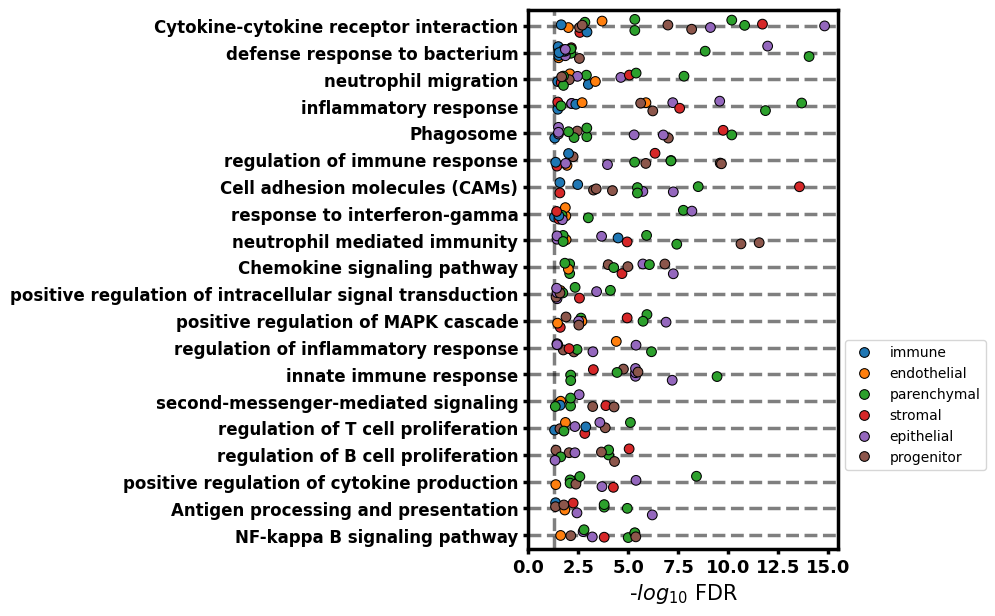

In [78]:
plt.figure(figsize = (4, 7))

#ax = sns.barplot(data = to_graph, x = 'nlog10p', y = 'term2', color = 'grey',
#                capsize = 0.5, lw = 1.5, errwidth = 0)


kwargs = {'edgecolor':'k', 'linewidth':0.75}

ax = sns.stripplot(data = to_graph, x = 'nlog10p', y = 'term2', s = 7, **kwargs,
                  hue = 'Class', jitter = .25,
                  hue_order = ['immune', 'endothelial', 'parenchymal', 'stromal', 'epithelial', 'progenitor'])



for x in range(len(top_20)):
#    plt.text(x = 0.1, y = x, s = str(round(top_20.iloc[x].Overlap/len(hubs),2)), va = 'center')
    ax.axhline(x, zorder = 0, ls = '--', c = 'k', alpha = 0.5, lw = 2.5)
    
    
ax.axvline(-np.log10(0.05), ls = '--', c = 'k', alpha = 0.5, lw = 2.5)

    
plt.xlim(left = 0)

ax.legend(bbox_to_anchor=(1, .4))



for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2.5)


plt.xticks(size = 13, ha = 'center', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')

ax.tick_params(width = 2.5)

plt.ylabel('')
plt.xlabel("-$log_{10}$ FDR", size = 15)

plt.ylim(top = -.6)

plt.savefig('figures/R1_4C.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_4C.svg', bbox_inches = 'tight', transparent = True)

plt.show()

# TF - signatures

In [55]:
out = []

for hub in tqdm(list(signatures)):
    
    #convert hub list to \n sep string
    seq_str = ''
    for item in [x[0] for x in signatures[hub]]:
        seq_str += str(item) + '\n'
    
    #pass that string to this R script which returns a gene region df
    child = subprocess.Popen(['scripts/tf/sym_to_reg.R'], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    child.stdin.write(seq_str.encode())
    child_out = child.communicate()[0].decode('utf8')
    a = StringIO(child_out)
    child.stdin.close()
    
    #read the region df and slice up mm10 into a multi seq fasta
    a = pd.read_csv(a).dropna().reset_index(drop = True)
    a['slice_start'] = a['slice_start'].astype('int')
    a['slice_end'] = a['slice_end'].astype('int')
    
    outfa = []
    for row in a.index:
        values = a.iloc[row]
        record = mm10[values.TXCHROM][values.slice_start - 1:values.slice_end -1]
        record.id = values.symbol

        outfa.append(record)
    
    
    with open('tmpdir/test.fasta', 'w') as f:
        for seq in outfa:
            f.write( '>' + seq.id + '\n')
            f.write(str(seq.seq) + '\n')
            
            
    #process fasta with meme sea     
    child = subprocess.Popen(['sea', '--p', 'tmpdir/test.fasta', '--m',
                          'scripts/tf/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt', 
                          '--text'], stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    child_out = child.communicate()[0].decode('utf8')
    a = StringIO(child_out)
    a = pd.read_csv(a, delimiter='\t').dropna().drop(columns = ['DB'])
    
    a['tissue'] = hub[0]
    a['cell'] = hub[1]
    
    out.append(a)

100%|█████████████████████████████████████████| 44/44 [1:13:10<00:00, 99.79s/it]


In [57]:
tf = pd.concat(out)

In [62]:
#tf.to_pickle('../data/files/R1_5.1_TMS_GENE_TF_ENRICHMENT_DF_SIGS.pickle')

In [63]:
tf = pd.read_pickle('../data/files/R1_5.1_TMS_GENE_TF_ENRICHMENT_DF_SIGS.pickle')

In [64]:
tf = tf[tf.QVALUE < 0.05]

In [65]:
top_20 = tf.groupby('ALT_ID').count().sort_values('RANK', ascending = False)[0:20]

order_d = dict(zip(top_20.index, range(20)))

overlap_d = dict(zip(top_20.index, top_20.RANK))

top_20

,RANK,ID,CONSENSUS,TP,TP%,FP,FP%,ENR_RATIO,SCORE_THR,PVALUE,LOG_PVALUE,EVALUE,LOG_EVALUE,QVALUE,LOG_QVALUE,tissue,cell
ALT_ID,,,,,,,,,,,,,,,,,
RREB1,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
KLF4,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39
KLF5,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
KLF9,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
IRF1,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
KLF16,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
ZNF460,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
EGR1,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
KLF15,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32


In [67]:
to_graph = tf[tf.ALT_ID.isin(top_20.index)]


#to_graph['nlog10p'] = -np.log10(to_graph['Adjusted P-value'])

to_graph['Orderer'] = to_graph.ALT_ID.map(order_d)

to_graph = to_graph.sort_values('Orderer')


to_graph['Overlap'] = to_graph.ALT_ID.map(overlap_d)

to_graph['frac'] = to_graph['Overlap']/len(signatures) * 100

to_graph['Class'] = to_graph.cell.map(class_d)


to_graph

/tmp/ipykernel_475417/2557413998.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_graph['Orderer'] = to_graph.ALT_ID.map(order_d)


,RANK,ID,ALT_ID,CONSENSUS,TP,TP%,FP,FP%,ENR_RATIO,SCORE_THR,...,EVALUE,LOG_EVALUE,QVALUE,LOG_QVALUE,tissue,cell,Orderer,Overlap,frac,Class
0,1,MA0073.1,RREB1,CCCCMAAMCAMCCMCMMMCV,654.0,60.89,270.0,25.14,2.42,4.10,...,1.770000e-61,-139.89,8.410000e-62,-140.63,Trachea,macrophage,0,40,90.909091,immune
1,2,MA0073.1,RREB1,CCCCMAAMCAMCCMCMMMCV,125.0,46.99,38.0,14.29,3.23,6.00,...,6.270000e-14,-30.40,1.820000e-14,-31.64,Kidney,distal convoluted tubule epithelial cell,0,40,90.909091,epithelial
3,4,MA0073.1,RREB1,CCCCMAAMCAMCCMCMMMCV,22.0,37.29,5.0,8.47,3.83,7.30,...,1.220000e-01,-2.10,2.900000e-02,-3.54,Myeloid,monocyte,0,40,90.909091,immune
2,3,MA0073.1,RREB1,CCCCMAAMCAMCCMCMMMCV,112.0,70.89,61.0,38.61,1.82,2.00,...,4.450000e-06,-12.32,1.020000e-06,-13.79,Lymphoid,B cell,0,40,90.909091,progenitor
2,3,MA0073.1,RREB1,CCCCMAAMCAMCCMCMMMCV,94.0,75.20,53.0,42.40,1.76,2.10,...,7.780000e-05,-9.46,1.950000e-05,-10.84,Pancreas,pancreatic A cell,0,40,90.909091,parenchymal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,14,MA0685.1,SP4,BWRGCCACGCCCMCTYH,333.0,31.01,125.0,11.64,2.65,7.70,...,6.950000e-26,-57.93,2.360000e-27,-61.31,Trachea,macrophage,19,29,65.909091,immune
27,28,MA0685.1,SP4,BWRGCCACGCCCMCTYH,26.0,61.90,10.0,23.81,2.45,2.10,...,1.540000e+00,0.43,2.840000e-02,-3.56,Heart_and_Aorta,endothelial cell,19,29,65.909091,endothelial
19,20,MA0685.1,SP4,BWRGCCACGCCCMCTYH,634.0,46.76,359.0,26.47,1.76,4.80,...,1.880000e-25,-56.93,4.510000e-27,-60.66,Liver,hepatocyte,19,29,65.909091,parenchymal
5,6,MA0685.1,SP4,BWRGCCACGCCCMCTYH,62.0,57.41,28.0,25.93,2.17,3.40,...,1.620000e-03,-6.43,2.380000e-04,-8.35,Myeloid,macrophage,19,29,65.909091,immune


In [68]:
to_graph['ENR_RATIO'][to_graph['ENR_RATIO'] > 10] = 10 #because of a few high outliers, make sure to add >= on plot

/tmp/ipykernel_475417/3884892461.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  to_graph['ENR_RATIO'][to_graph['ENR_RATIO'] > 10] = 10 #because of a few high outliers, make sure to add >= on plot
/tmp/ipykernel_475417/3884892461.py:1: S

### Fig 4D

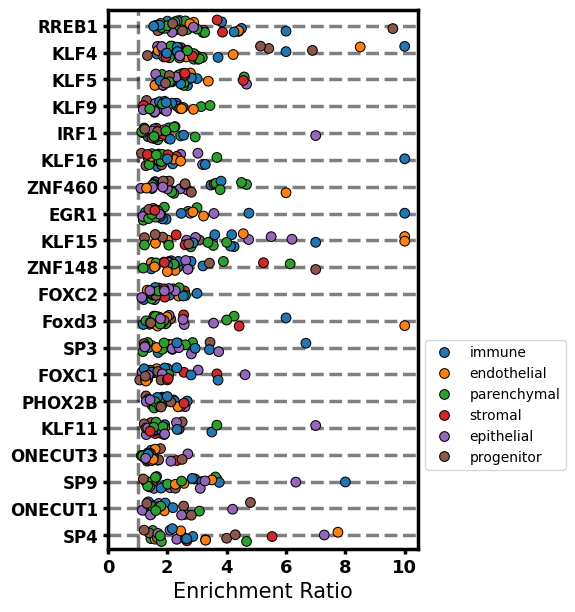

In [69]:
#note the few above 10 have been reduced to 10

plt.figure(figsize = (4, 7))

#ax = sns.barplot(data = to_graph, x = 'ENR_RATIO', y = 'ALT_ID', color = 'grey',
#                capsize = 0.5, lw = 1.5, errwidth = 0)


kwargs = {'edgecolor':'k', 'linewidth':0.75}

ax = sns.stripplot(data = to_graph, x = 'ENR_RATIO', y = 'ALT_ID', s = 7, **kwargs,
                  hue = 'Class', jitter = .25,
                  hue_order = ['immune', 'endothelial', 'parenchymal', 'stromal', 'epithelial', 'progenitor'])



for x in range(len(top_20)):
   # plt.text(x = 0.1, y = x, s = str(round(top_20.iloc[x].Overlap/len(hubs),2)), va = 'center')
    ax.axhline(x, zorder = 0, ls = '--', c = 'k', alpha = 0.5, lw = 2.5)

ax.axvline(1,zorder = 0, ls = '--', c = 'k', alpha = 0.5, lw = 2.5)
    
plt.xlim(left = 0)

ax.legend(bbox_to_anchor=(1, .4))



for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2.5)


plt.xticks(size = 13, ha = 'center', weight = 'bold')
plt.yticks(size = 12, weight = 'bold')

ax.tick_params(width = 2.5)

plt.ylabel('')
plt.xlabel("Enrichment Ratio", size = 15)

plt.ylim(top = -.6)

plt.savefig('figures/R1_4D.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_4D.svg', bbox_inches = 'tight', transparent = True)

plt.show()

In [70]:
test = tf.groupby('ALT_ID').count().sort_values('RANK', ascending = False)

test[test.RANK >= 24].shape #how TF with enriched in more than 50% of signatures

(44, 17)

# Revision 1 - Reviewer 2: How does universal signature compare to 330 global aging genes from Zhang et al 2021

In [1]:
import senepy as sp

In [6]:
temp = pd.read_csv('../data/gene_lists/elife-62293-supp3-v2-1_aging_sig.csv') #this file has global aging signature doi.org/10.6084/m9.figshare.12827615.v1
gags = set(temp[temp.global_aging == 1].gene.values)

In [7]:
hubs = sp.load_hubs(species = 'Mouse', sig_type = 'cell_type')

In [8]:
#get Universal sig
hubs.merge_hubs(hubs.metadata, new_name = 'Universal',
                calculate_thresh = True,
                bg_N = len(adata.var_names), p_thres=0.01)

A gene will occur 5 times at 0.37% chance
Threfore 5 is the calculated_threshold


,Gene,Count,p value,q value
0,Hba-a1,29,0.000000,0.000000
1,Hbb-b1,20,0.000000,0.000000
2,Gm11428,19,0.000000,0.000000
3,Vsig4,18,0.000000,0.000000
4,Saa3,18,0.000000,0.000000
...,...,...,...,...
630,Cd300lf,5,0.000246,0.003735
631,Prkcb,5,0.000246,0.003735
632,Enpp6,5,0.000246,0.003735
633,Slc4a8,5,0.000246,0.003735


In [9]:
sen_universal = set([x[0] for x in hubs.hubs['Universal']])

In [10]:
len(sen_universal)

635

In [11]:
len(gags)

330

In [12]:
sen_universal.intersection(gags)

set()

In [13]:
#GAGS
stats.hypergeom.cdf(len(sen_universal.intersection(gags)),
                              len(adata.var_names), len(sen_universal), len(gags)) #Note: cdf not sf


#chance that there is 0 or fewer genes in the overlap

2.313892451331335e-05

In [14]:
#lets try the sen gene set instead

In [15]:
sen_markers = set(hubs.literature_markers)

In [16]:
sen_universal.intersection(sen_markers)

{'C3',
 'Ccl11',
 'Ccl17',
 'Ccl22',
 'Ccl24',
 'Ccl3',
 'Ccl4',
 'Ccl5',
 'Ccl7',
 'Ccl8',
 'Ccl9',
 'Cdkn2a',
 'Cdkn2b',
 'Csf1',
 'Csf2rb',
 'Cxcl13',
 'Cxcl3',
 'Cxcr2',
 'Gmfg',
 'Ifi204',
 'Il1b',
 'Il6',
 'Il7',
 'Irf7',
 'Mmp23',
 'Mmp3',
 'Mmp8',
 'Pgf',
 'Tnf'}

In [27]:
stats.hypergeom.sf(len(sen_universal.intersection(sen_markers)),
                              len(adata.var_names), len(sen_universal), len(sen_markers)) #note: sf

#enrichment of the senePy universal signature for known sen markers

1.3739253909014361e-13

In [ ]:
#should I add this to fig 4B/F?

In [33]:
M = len(adata.var_names)
n = len(sen_universal)
N = len(gags)
x_obs = len(sen_universal.intersection(gags))

In [37]:
expected_overlap = stats.hypergeom.mean(M, n, N)
expected_overlap

10.417080930602506

In [ ]:
#bar plot of senpy and GAG enrichment of known sen genes

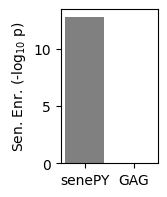

In [98]:
a = stats.hypergeom.sf(len(sen_universal.intersection(sen_markers)),
                              len(adata.var_names), len(sen_universal), len(sen_markers))

b = stats.hypergeom.sf(len(gags.intersection(sen_markers)),
                              len(adata.var_names), len(sen_universal), len(gags))

a = -np.log10(a)
b = -np.log10(b)


plt.figure(figsize = (1.25,2))
ax = plt.bar(['senePY', 'GAG'], [a, b], color='grey')

plt.ylabel(r'Sen. Enr. (-log$_{10}$ p)')

plt.savefig('figures/R1_uni_vs_gag_enr.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_uni_vs_gag_enr.svg', bbox_inches = 'tight', transparent = True)

plt.show()

In [99]:
print(a,b)

12.86203685039115 0.0028916168051210268


In [100]:
stats.hypergeom.sf(len(gags.intersection(sen_markers)),
                              len(adata.var_names), len(sen_universal), len(gags))

0.9933639229089941

In [ ]:
#CDF of senepy GAG overlap

In [90]:
x = range(0,25)
cdf = stats.hypergeom.cdf(x, M, n, N)

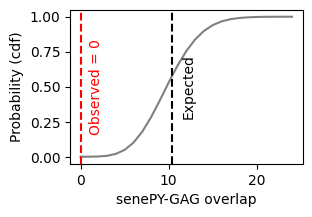

In [97]:
plt.figure(figsize=(3, 2))
ax = sns.lineplot(x=x, y=cdf, color = 'grey')
plt.axvline(x_obs, color='red', linestyle='--')
plt.axvline(expected_overlap, color='k', linestyle='--')

plt.text(x_obs + 1, 0.5,
         'Observed = 0',
         rotation=90,
         verticalalignment='center',
         color='red')


plt.text(expected_overlap + 1, 0.5,
         'Expected',
         rotation=90,
         verticalalignment='center',
         color='k')



plt.xlabel('senePY-GAG overlap')
plt.ylabel('Probability (cdf)')

plt.savefig('figures/R1_uni_vs_gag.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_uni_vs_gag.svg', bbox_inches = 'tight', transparent = True)

plt.show()

In [43]:
[x for x in hubs.hubs['Universal'] if x[0] == 'Cdkn2a']

[('Cdkn2a', 12)]

## R1 Reviewer 3


universal signature in cell class

In [1]:
import senepy as sp

In [5]:
hubs = sp.load_hubs(species = 'Mouse', sig_type = 'cell_type')

In [22]:
hubs.metadata[hubs.metadata.cell == 'fibroblast']

,tissue,cell,size,n_sen,hyp
10,Heart_and_Aorta,fibroblast,130,7,1.959923e-04
30,Lung,fibroblast,796,23,1.099091e-06
41,Trachea,fibroblast,910,29,4.261672e-09


In [23]:
a = hubs.merge_hubs(hubs.metadata[hubs.metadata.cell == 'fibroblast'], new_name = 'a', calculate_thresh = True)

A gene will occur 1 times at 0.15% chance
Threfore 1 is the calculated_threshold


In [25]:
a[a.Count == 3]

,Gene,Count,p value,q value
0,Saa3,3,2.220446e-16,2.382221e-14
1,Vsig4,3,2.220446e-16,2.382221e-14
2,Hbb-b1,3,2.220446e-16,2.382221e-14
3,Csf2rb2,3,2.220446e-16,2.382221e-14
4,Lyz1,3,2.220446e-16,2.382221e-14
5,Slfn2,3,2.220446e-16,2.382221e-14
6,Hba-a1,3,2.220446e-16,2.382221e-14
7,Ccl9,3,2.220446e-16,2.382221e-14
8,Cd300lg,3,2.220446e-16,2.382221e-14
9,Lrg1,3,2.220446e-16,2.382221e-14


In [21]:
hubs.metadata[hubs.metadata.cell == 'endothelial cell']

,tissue,cell,size,n_sen,hyp
1,Bladder,endothelial cell,36,1,0.281863
5,Fat,endothelial cell,416,12,0.000466
9,Heart_and_Aorta,endothelial cell,50,4,0.001124


In [16]:
hubs.merge_hubs(hubs.metadata[hubs.metadata.cell == 'endothelial cell'],
                new_name = 'a', calculate_thresh = True)

A gene will occur 1 times at 0.01% chance
Threfore 1 is the calculated_threshold


,Gene,Count,p value,q value
0,AA467197,3,0.000000e+00,0.000000
1,Pf4,2,4.792320e-08,0.000001
2,H2-T10,2,4.792320e-08,0.000001
3,Timm8a1,2,4.792320e-08,0.000001
4,Cdkn2a,2,4.792320e-08,0.000001
...,...,...,...,...
479,Prosapip1,1,6.002575e-05,0.000060
480,Sema5b,1,6.002575e-05,0.000060
481,Fam158a,1,6.002575e-05,0.000060
482,Dtx4,1,6.002575e-05,0.000060


In [18]:
hubs.metadata[hubs.metadata.cell.str.contains('macrophage')]

,tissue,cell,size,n_sen,hyp
18,Kidney,macrophage,365,12,0.000142
24,Limb_Muscle,macrophage,229,3,0.349170
29,Lung,alveolar macrophage,47,0,1.000000
34,Myeloid,macrophage,139,1,0.722434
42,Trachea,macrophage,1333,21,0.010501


In [26]:
hubs.merge_hubs(hubs.metadata[hubs.metadata.cell.str.contains('macrophage')],
                new_name = 'a', calculate_thresh = True)

A gene will occur 1 times at 0.19% chance
Threfore 1 is the calculated_threshold


,Gene,Count,p value,q value
0,Lcn2,4,7.453682e-11,3.613172e-08
1,Chi3l3,4,7.453682e-11,3.613172e-08
2,Hba-a1,4,7.453682e-11,3.613172e-08
3,Prtn3,4,7.453682e-11,3.613172e-08
4,Elane,3,6.739542e-08,7.259985e-06
...,...,...,...,...
1934,Abcb8,1,1.948036e-03,1.948036e-03
1935,Szt2,1,1.948036e-03,1.948036e-03
1936,Ubxn2b,1,1.948036e-03,1.948036e-03
1937,Tnfrsf8,1,1.948036e-03,1.948036e-03


In [27]:
4/5

0.8